## Evaluation

#### **verbs that we used in the study**
- 4 ES, 4SE, 4 positive sentiment, 4 negative sentiment:
    - faszinieren ("fascinate") (SE)
    - inspirieren ("inspire") (SE)
    - enttäuschen ("disappoint") (SE)
    - schockieren ("shock") (SE)
    - bewundern ("admire") (ES)
    - respektieren ("respect") (ES)
    - verabscheuen ("despise") (ES)
    - hassen ("hate") (ES)


#### **verbs that we use for hyperparameter testing**
- 4 ES, 4SE, 4 positive sentiment, 4 negative sentiment
    - stören ("disturb"/"bother") (SE)
    - langeweilen ("bore") (SE)
    - entzücken ("delight") (SE)
    - amüsieren ("amuse") (SE)
    - fürchten ("fear") (ES)
    - beneiden ("envy") (ES)
    - Mitleid mit DP haben ("have pity with DP") (ES)
    - vergöttern  ("idolize"/"adore") (ES)


### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import json
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

from datasets import load_metric
from datasets import list_metrics
import evaluate 
from evaluate import load
bleu_metric = evaluate.load("bleu")
bertscore_metric= load("bertscore")
rouge_metric = evaluate.load('rouge')

### Load and preprocess the data 

In [2]:
### model generations
with open("../data/pkl_files/gpt2.pkl", "rb") as fp: 
    gpt2_data = pickle.load(fp)
    
with open("../data/pkl_files/mgpt.pkl", "rb") as fp: 
    mgpt_data = pickle.load(fp)
    

In [3]:
### human evaluation data
df = pd.read_csv('../data/results_human_eval.csv', delimiter=";")

# only keep the important columns
df = df[["SUBJECT_ID", "PROMPT_COND", "EXP_LIST", "DECODING", "MODEL", 
         "VERB", "SENTIMENT", "ARGTYPE", "GENDER ", "ITEM", "BIAS",
         "NATURALNESS", "COHERENCE", "INFORMATIVITY"]]

# need to exclude participants that cancelled the experiment in between
# Use boolean indexing to exclude rows where SUBJECT_ID is "xyz"
df = df[df['SUBJECT_ID'] != 'a39bnv0dtbucqf3qgf2njj46da']
df = df[df['SUBJECT_ID'] != 'j2v0g267emtbki0f7ri2lc0lhj']
df = df[df['SUBJECT_ID'] != '3llabiinb4dhmnmafqh42ilmjr']
df = df[df['SUBJECT_ID'] != 'nb1tnfj5171uifq71e670bupli']
df = df[df['SUBJECT_ID'] != 'cb2t9o0fjrc976bud36b3ccos2']
df = df[df['SUBJECT_ID'] != 'cs3q2e0icemu3486rfkbpb10bc']
df = df[df['SUBJECT_ID'] != 'd8klu2opff9v7p6jn87ev14i8b']

print("Number of participants:", len(set(df["SUBJECT_ID"])))


Number of participants: 40


In [4]:
## Exclude some unnecessary data from the human evaluation data and rename some values so it is all a little prettier:
##Prompt Condition
# Specify the values to include
values_to_include = ['<id:\tPROMPT_COND\tcontroll\t',
                     '<id:\tPROMPT_COND\tnames_pp\t',
                     '<id:\tPROMPT_COND\tnames_simple\t',
                     '<id:\tPROMPT_COND\tnames_simple \t']

# Use boolean indexing to include only rows where PROMPT_COND is in the specified values
df = df[df['PROMPT_COND'].isin(values_to_include)]

# Specify the old and new values to replace
value_mapping = {'<id:\tPROMPT_COND\tcontroll\t': 'control',
                 '<id:\tPROMPT_COND\tnames_pp\t': 'names_pp',
                 '<id:\tPROMPT_COND\tnames_simple\t': 'names_simple',
                 '<id:\tPROMPT_COND\tnames_simple \t': 'names_simple'}

# Replace the old values with the new values
df['PROMPT_COND'] = df['PROMPT_COND'].replace(value_mapping)

## Experimental list Condition
# Specify the old and new values to replace
value_mapping = {'\tEXP_LIST\t1\t': 'List1',
                 '\tEXP_LIST\t2\t': 'List2'}

# Replace the old values with the new values
df['EXP_LIST'] = df['EXP_LIST'].replace(value_mapping)

## Decoding procedure Condition
# Specify the old and new values to replace
value_mapping = {'\tDECODING\tcontroll\t': 'controll',
                 '\tDECODING\tdiverse_beam\t': 'diverse beam search', 
                 '\tDECODING\thuman_bias_congruent\t': "human_bias_congruent",
                 '\tDECODING\thuman_bias_incongruent\t': "human_bias_incongruent", 
                 '\tDECODING\tnucleus_samp\t': "nucleus sampling", 
                 '\tDECODING\ttypical_samp\t':'typical sampling'}

# Replace the old values with the new values
df['DECODING'] = df['DECODING'].replace(value_mapping)

## Model condition
# Specify the old and new values to replace
value_mapping = {'\tMODEL\tcontroll\t': 'controll',
                 '\tMODEL\tgpt2\t': 'gpt2', 
                 '\tMODEL\thuman\t': "human",
                 '\tMODEL\tmGPT\t': "mGPT"}

# Replace the old values with the new values
df['MODEL'] = df['MODEL'].replace(value_mapping)


## Verb condition
# Specify the old and new values to replace
value_mapping = {'\tVERB\tbewundern\t': 'bewundern',
                 '\tVERB\tcontroll\t': 'controll',
                 '\tVERB\tenttäuschen\t': 'enttäuschen',
                 '\tVERB\tentzücken\t': 'entzücken',
                 '\tVERB\tfaszinieren\t': 'faszinieren',
                 '\tVERB\thassen \t': 'hassen',
                 '\tVERB\tinspirieren\t': 'inspirieren',
                 '\tVERB\tlangeweilen \t': 'langeweilen',
                 '\tVERB\trespektieren\t': 'respektieren',
                 '\tVERB\tschockieren\t': 'schockieren',
                 '\tVERB\tverabscheuen\t': 'verabscheuen'}

# Replace the old values with the new values
df['VERB'] = df['VERB'].replace(value_mapping)

## Sentiment condition
# Specify the old and new values to replace
value_mapping = {'\tSENT\tcontroll\t': 'controll',
                 '\tSENT\tnegative\t': 'negative', 
                 '\tSENT\tpositive\t': "positive"}

# Replace the old values with the new values
df['SENTIMENT'] = df['SENTIMENT'].replace(value_mapping)

## Argtype condition
# Specify the old and new values to replace
value_mapping = {'\tARGTYPE\tES\t': 'ES',
                 '\tARGTYPE\tSE\t': 'SE', 
                 '\tcontroll\tcontroll\t': "controll"}

# Replace the old values with the new values
df['ARGTYPE'] = df['ARGTYPE'].replace(value_mapping)


## Gender condition
# Specify the old and new values to replace
value_mapping = {'\tGENDER\tcontroll\t': 'controll',
                 '\tGENDER\tf-m\t': 'f-m', 
                 '\tGENDER\tm-f\t': "m-f"}

# Replace the old values with the new values
df['GENDER '] = df['GENDER '].replace(value_mapping)


## Item condition
# Specify the old and new values to replace
value_mapping = {'\tITEM\t1\t': 1,
                 '\tITEM\t2\t': 2,
                 '\tITEM\t3\t': 3,
                 '\tITEM\t4\t': 4,
                 '\tITEM\t5\t': 5,
                 '\tITEM\t6\t': 6,
                 '\tITEM\t7\t': 7,
                 '\tITEM\t8\t': 8,
                 '\tITEM\t9\t': 9,
                 '\tITEM\t10\t': 10,
                 '\tITEM\t11\t': 11,
                 '\tITEM\t12\t': 12,
                 '\tITEM\t13\t': 13,
                 '\tITEM\t14\t': 14,
                 '\tITEM\t15\t': 15,
                 '\tITEM\t16\t': 16,
                 '\tITEM\t17\t': 17,
                 '\tITEM\t18\t': 18,
                 '\tITEM\t19\t': 19,
                 '\tITEM\t20\t': 20,
                 '\tITEM\t21\t': 21,
                 '\tITEM\t22\t': 22,
                 '\tITEM\t23\t': 23,
                 '\tITEM\t24\t': 24,
                 '\tITEM\t25\t': 25,
                 '\tITEM\t26\t': 26,
                 '\tITEM\t27\t': 27,
                 '\tITEM\t28\t': 28,
                 '\tITEM\t29\t': 29,
                 '\tITEM\t30\t': 30,
                 '\tITEM\t31\t': 31,
                 '\tITEM\t32\t': 32,
                 '\tITEM\tcontroll1\t': 'controll1',
                 '\tITEM\tcontroll2\t': 'controll2',
                 '\tITEM\tuebung1\t': 'uebung1',
                 '\tITEM\tuebung2\t': 'uebung2'}

# Replace the old values with the new values
df['ITEM'] = df['ITEM'].replace(value_mapping)

# Bias colum
df['BIAS'] = df['BIAS'].map({'\tBIAS\t\t>': 'NA',
                             '\tBIAS\t0\t>': '0',
                             '\tBIAS\t1\t>': '1',
                             '\tBIAS\tcontroll-links\t>': 'controll-links',
                             '\tBIAS\tcontroll-rechts\t>': 'controll-rechts'})

In [5]:
## for analysis: exclude the controll and the uebungsitems!
df = df[df['DECODING'] != 'controll']
df = df[(df['ITEM'] != 'uebung2') & (df['ITEM'] != 'uebung1')]
## also exclude the na values: 
df = df[df['BIAS'] != 'NA']

In [6]:
df

,SUBJECT_ID,PROMPT_COND,EXP_LIST,DECODING,MODEL,VERB,SENTIMENT,ARGTYPE,GENDER,ITEM,BIAS,NATURALNESS,COHERENCE,INFORMATIVITY
10,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,human_bias_congruent,human,verabscheuen,negative,ES,m-f,8,1,5.0,5.0,1.0
14,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,nucleus sampling,mGPT,respektieren,positive,ES,m-f,16,1,1.0,1.0,2.0
16,fgsg25d1h6kbtg5r8t1fdc04qg,names_simple,List1,human_bias_congruent,human,verabscheuen,negative,ES,f-m,13,1,5.0,5.0,1.0
17,001eu13ge632itrh1ksicn0t1t,names_simple,List1,typical sampling,gpt2,hassen,negative,ES,f-m,9,1,4.0,5.0,4.0
18,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,nucleus sampling,gpt2,faszinieren,positive,SE,f-m,4,1,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,typical sampling,mGPT,enttäuschen,negative,SE,f-m,29,0,5.0,5.0,1.0
5766,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,nucleus sampling,mGPT,schockieren,negative,SE,m-f,21,0,1.0,1.0,5.0
5767,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,typical sampling,gpt2,respektieren,positive,ES,m-f,15,1,5.0,5.0,1.0
5768,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,diverse beam search,gpt2,faszinieren,positive,SE,m-f,5,1,5.0,5.0,1.0


#### Calculate some basic statistics... 

In [7]:
# Subsets.. 
#subset = df[(df['MODEL'] == 'gpt2') & (df['PROMPT_COND'] == 'names_simple')]
subset = df[(df['PROMPT_COND'] == 'names_simple')]

# Descriptive statistics for "NATURALNESS"
print("Descriptive statistics for NATURALNESS")
print(subset['NATURALNESS'].describe())

# Mean COHERENCE for the subset
mean_coherence = subset['COHERENCE'].mean()
print("Mean COHERENCE for the subset:", mean_coherence)

# Proportion of ratings of 4 or 5 for INFORMATIVITY
prop_high_info = subset[subset['INFORMATIVITY'] >= 4]['INFORMATIVITY'].count() / subset['INFORMATIVITY'].count()
print("Proportion of ratings of 3 or 5 for INFORMATIVITY:", prop_high_info)

Descriptive statistics for NATURALNESS
count    2483.000000
mean        3.594442
std         1.415439
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: NATURALNESS, dtype: float64
Mean COHERENCE for the subset: 3.0370519532823197
Proportion of ratings of 3 or 5 for INFORMATIVITY: 0.220700765203383


----
### Automatic Evaluation of model generations

In [8]:
## create subsets to evaluate the different conditions

def create_lists_for_eval(datadict):
    simple_references = []
    diverse_beam_simple =[]
    nucleus_sampling_simple = []
    typical_sampling_simple= []

    modified_references = []
    diverse_beam_modified =[]
    nucleus_sampling_modified = []
    typical_sampling_modified = []
    
    count= 0
    for verb in datadict:
        for i in range(0,(len(datadict[verb]["prompt"]))):
            if datadict[verb]["prompt_condition"][i] == "names_simple" or datadict[verb]["prompt_condition"][i] == "names_simple ":
                simple_references.append(datadict[verb]["human_reference"][i])
                diverse_beam_simple.append(" ".join(datadict[verb]["model_generation_diversebeam"][i].partition(",")[2].split()[1:]))
                nucleus_sampling_simple.append(" ".join(datadict[verb]["model_generation_nucleus_sampling"][i].partition(",")[2].split()[1:]))
                typical_sampling_simple.append(" ".join(datadict[verb]["model_generation_typical_sampling"][i].partition(",")[2].split()[1:]))

            elif datadict[verb]["prompt_condition"][i] == "names_pp":
                modified_references.append(datadict[verb]["human_reference"][i])
                diverse_beam_modified.append(" ".join(datadict[verb]["model_generation_diversebeam"][i].partition(",")[2].split()[1:]))
                nucleus_sampling_modified.append(" ".join(datadict[verb]["model_generation_nucleus_sampling"][i].partition(",")[2].split()[1:]))
                typical_sampling_modified.append(" ".join(datadict[verb]["model_generation_typical_sampling"][i].partition(",")[2].split()[1:]))

                
    return simple_references, diverse_beam_simple, nucleus_sampling_simple, typical_sampling_simple, modified_references, diverse_beam_modified, nucleus_sampling_modified, typical_sampling_modified



In [9]:
## call the function for each model
gpt2_simple_references, gpt2_diverse_beam_simple, gpt2_nucleus_sampling_simple, gpt2_typical_sampling_simple, gpt2_modified_references, gpt2_diverse_beam_modified, gpt2_nucleus_sampling_modified, gpt2_typical_sampling_modified = create_lists_for_eval(gpt2_data)

mgpt_simple_references, mgpt_diverse_beam_simple, mgpt_nucleus_sampling_simple, mgpt_typical_sampling_simple, mgpt_modified_references, mgpt_diverse_beam_modified, mgpt_nucleus_sampling_modified, mgpt_typical_sampling_modified = create_lists_for_eval(mgpt_data)


#### BLEU

In [10]:
bleu_metric = evaluate.load("bleu")

In [11]:
#gpt2_diverse_beam_modified #preds: ["pred1", "pred2", "pred3", ...]
#gpt2_simple_references #refs: [["ref1 for pred1 ", "ref2 for pred 1"], ["ref 1 for pred2","ref 2 for pred 2"]]

In [12]:
bleuscore = bleu_metric.compute(references=gpt2_modified_references,
                                predictions=gpt2_nucleus_sampling_modified)

round(bleuscore['precisions'][0],3)
bleuscore

{'bleu': 0.0,
 'precisions': [0.3772455089820359,
  0.06622516556291391,
  0.014814814814814815,
  0.0],
 'brevity_penalty': 2.0844027246145067e-05,
 'length_ratio': 0.08490086426029486,
 'translation_length': 167,
 'reference_length': 1967}

In [13]:
bleuscore["precisions"][0]

0.3772455089820359

#### ROUGE

In [14]:
rouge_metric = evaluate.load('rouge')

In [15]:
rougescore = rouge_metric.compute(references=gpt2_modified_references,
                                  predictions=mgpt_typical_sampling_modified)

round(rougescore["rougeL"],3)

0.056

#### BERTScore

In [16]:
bertscore_metric= load("bertscore")

In [17]:
bertscore = bertscore_metric.compute(references=gpt2_modified_references,
                                     predictions=mgpt_typical_sampling_modified, 
                                     lang="de")

round(bertscore['f1'][0],3)

0.58

----
### Visualizations 

#### Relation between prompt condition and decoding procedure

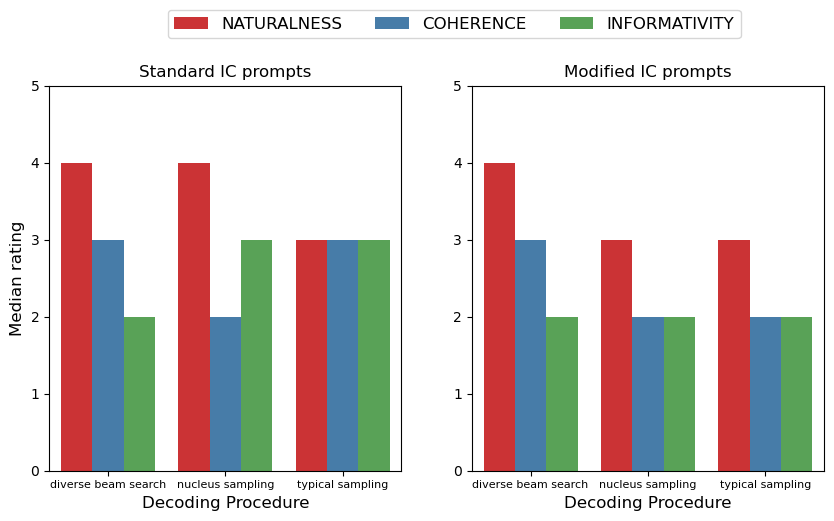

In [18]:
##### aggregated over both models #####

# Filter data for the first plot
df_names_simple = df[(df['PROMPT_COND'] == 'names_simple') & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat = df_names_simple.groupby('DECODING')['NATURALNESS'].median()
med_coh = df_names_simple.groupby('DECODING')['COHERENCE'].median()
med_info = df_names_simple.groupby('DECODING')['INFORMATIVITY'].median()
med_df = pd.DataFrame({'NATURALNESS': med_nat, 'COHERENCE': med_coh, 'INFORMATIVITY': med_info}).reset_index()
med_df_melt = pd.melt(med_df, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Filter data for the second plot
df_names_pp = df[(df['PROMPT_COND'] == 'names_pp') & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat2 = df_names_pp.groupby('DECODING')['NATURALNESS'].median()
med_coh2 = df_names_pp.groupby('DECODING')['COHERENCE'].median()
med_info2 = df_names_pp.groupby('DECODING')['INFORMATIVITY'].median()
med_df2 = pd.DataFrame({'NATURALNESS': med_nat2, 'COHERENCE': med_coh2, 'INFORMATIVITY': med_info2}).reset_index()
med_df_melt2 = pd.melt(med_df2, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot
ax = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt, ax=axs[0],  palette="Set1")
ax.set(ylim=(0, 5))
ax.set_xlabel('Decoding Procedure',fontsize=12)
ax.set_ylabel('Median rating', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)  # Set font size of x-axis label
ax.set_title('Standard IC prompts',fontsize=12)
#ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=12)
ax.legend(loc='center', ncol=3, bbox_to_anchor=(1.15, 1.16), fontsize=12)


# Second plot
ax2 = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt2, ax=axs[1],  palette="Set1")
ax2.set(ylim=(0, 5))
ax2.set_xlabel('Decoding Procedure',fontsize=12)
#ax2.set_ylabel('Median rating', fontsize=12)
ax2.set_ylabel('')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax2.set_title('Modified IC prompts',fontsize=12)
ax2.legend_.remove()


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

plt.show()


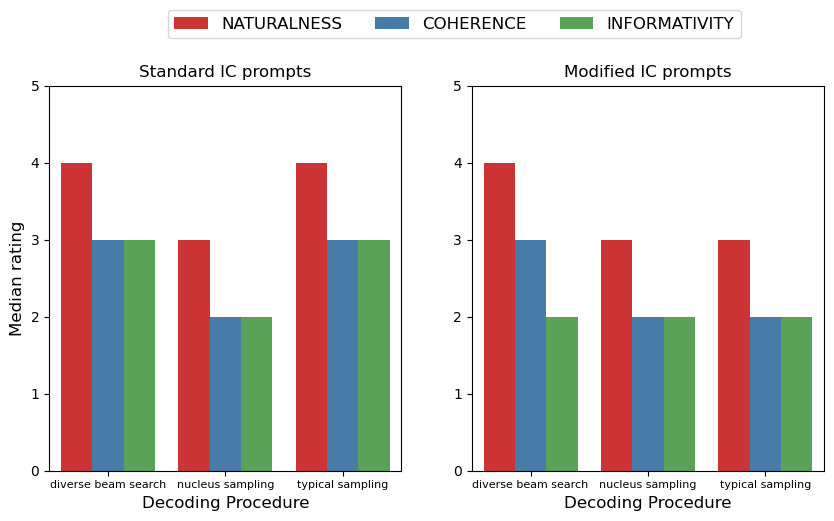

In [19]:
##### gpt-2 #####

# Filter data for the first plot
df_names_simple = df[(df['PROMPT_COND'] == 'names_simple') & (df['MODEL'] == 'gpt2') 
                     & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat = df_names_simple.groupby('DECODING')['NATURALNESS'].median()
med_coh = df_names_simple.groupby('DECODING')['COHERENCE'].median()
med_info = df_names_simple.groupby('DECODING')['INFORMATIVITY'].median()
med_df = pd.DataFrame({'NATURALNESS': med_nat, 'COHERENCE': med_coh, 'INFORMATIVITY': med_info}).reset_index()
med_df_melt = pd.melt(med_df, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Filter data for the second plot
df_names_pp = df[(df['PROMPT_COND'] == 'names_pp') & (df['MODEL'] == 'mGPT') 
                 & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat2 = df_names_pp.groupby('DECODING')['NATURALNESS'].median()
med_coh2 = df_names_pp.groupby('DECODING')['COHERENCE'].median()
med_info2 = df_names_pp.groupby('DECODING')['INFORMATIVITY'].median()
med_df2 = pd.DataFrame({'NATURALNESS': med_nat2, 'COHERENCE': med_coh2, 'INFORMATIVITY': med_info2}).reset_index()
med_df_melt2 = pd.melt(med_df2, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot
ax = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt, ax=axs[0],  palette="Set1")
ax.set(ylim=(0, 5))
ax.set_xlabel('Decoding Procedure',fontsize=12)
ax.set_ylabel('Median rating', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)  # Set font size of x-axis label
ax.set_title('Standard IC prompts',fontsize=12)
#ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=12)
ax.legend(loc='center', ncol=3, bbox_to_anchor=(1.15, 1.16), fontsize=12)


# Second plot
ax2 = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt2, ax=axs[1],  palette="Set1")
ax2.set(ylim=(0, 5))
ax2.set_xlabel('Decoding Procedure',fontsize=12)
#ax2.set_ylabel('Median rating', fontsize=12)
ax2.set_ylabel('')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax2.set_title('Modified IC prompts',fontsize=12)
ax2.legend_.remove()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

plt.show()


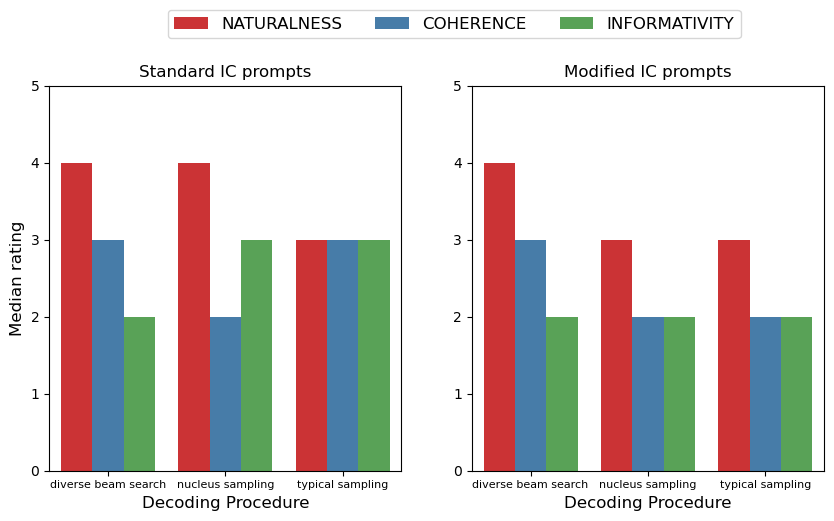

In [20]:
##### mGPT #####

# Filter data for the first plot
df_names_simple = df[(df['PROMPT_COND'] == 'names_simple') & (df['MODEL'] == 'mGPT') 
                     & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat = df_names_simple.groupby('DECODING')['NATURALNESS'].median()
med_coh = df_names_simple.groupby('DECODING')['COHERENCE'].median()
med_info = df_names_simple.groupby('DECODING')['INFORMATIVITY'].median()
med_df = pd.DataFrame({'NATURALNESS': med_nat, 'COHERENCE': med_coh, 'INFORMATIVITY': med_info}).reset_index()
med_df_melt = pd.melt(med_df, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Filter data for the second plot
df_names_pp = df[(df['PROMPT_COND'] == 'names_pp') & (df['MODEL'] == 'mGPT') 
                 & ~(df['DECODING'].isin(['human_bias_congruent', 'human_bias_incongruent']))]
med_nat2 = df_names_pp.groupby('DECODING')['NATURALNESS'].median()
med_coh2 = df_names_pp.groupby('DECODING')['COHERENCE'].median()
med_info2 = df_names_pp.groupby('DECODING')['INFORMATIVITY'].median()
med_df2 = pd.DataFrame({'NATURALNESS': med_nat2, 'COHERENCE': med_coh2, 'INFORMATIVITY': med_info2}).reset_index()
med_df_melt2 = pd.melt(med_df2, id_vars='DECODING', value_vars=['NATURALNESS', 'COHERENCE', 'INFORMATIVITY'], var_name='Rating')

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot
ax = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt, ax=axs[0],  palette="Set1")
ax.set(ylim=(0, 5))
ax.set_xlabel('Decoding Procedure',fontsize=12)
ax.set_ylabel('Median rating', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)  # Set font size of x-axis label
ax.set_title('Standard IC prompts',fontsize=12)
#ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=12)
ax.legend(loc='center', ncol=3, bbox_to_anchor=(1.15, 1.16), fontsize=12)


# Second plot
ax2 = sns.barplot(x='DECODING', y='value', hue='Rating', data=med_df_melt2, ax=axs[1],  palette="Set1")
ax2.set(ylim=(0, 5))
ax2.set_xlabel('Decoding Procedure',fontsize=12)
#ax2.set_ylabel('Median rating', fontsize=12)
ax2.set_ylabel('')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax2.set_title('Modified IC prompts',fontsize=12)
ax2.legend_.remove()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

plt.show()


#### Relation between bias congruency and human evaluation criteria 

In [118]:
df

,SUBJECT_ID,PROMPT_COND,EXP_LIST,DECODING,MODEL,VERB,SENTIMENT,ARGTYPE,GENDER,ITEM,BIAS,NATURALNESS,COHERENCE,INFORMATIVITY
10,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,human_bias_congruent,human,verabscheuen,negative,ES,m-f,8,1,5.0,5.0,1.0
14,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,nucleus sampling,mGPT,respektieren,positive,ES,m-f,16,1,1.0,1.0,2.0
16,fgsg25d1h6kbtg5r8t1fdc04qg,names_simple,List1,human_bias_congruent,human,verabscheuen,negative,ES,f-m,13,1,5.0,5.0,1.0
17,001eu13ge632itrh1ksicn0t1t,names_simple,List1,typical sampling,gpt2,hassen,negative,ES,f-m,9,1,4.0,5.0,4.0
18,fgsg25d1h6kbtg5r8t1fdc04qg,names_pp,List1,nucleus sampling,gpt2,faszinieren,positive,SE,f-m,4,1,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,typical sampling,mGPT,enttäuschen,negative,SE,f-m,29,0,5.0,5.0,1.0
5766,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,nucleus sampling,mGPT,schockieren,negative,SE,m-f,21,0,1.0,1.0,5.0
5767,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,typical sampling,gpt2,respektieren,positive,ES,m-f,15,1,5.0,5.0,1.0
5768,evk29205i2rvua7q4ffa7k3kqp,names_simple,List2,diverse beam search,gpt2,faszinieren,positive,SE,m-f,5,1,5.0,5.0,1.0


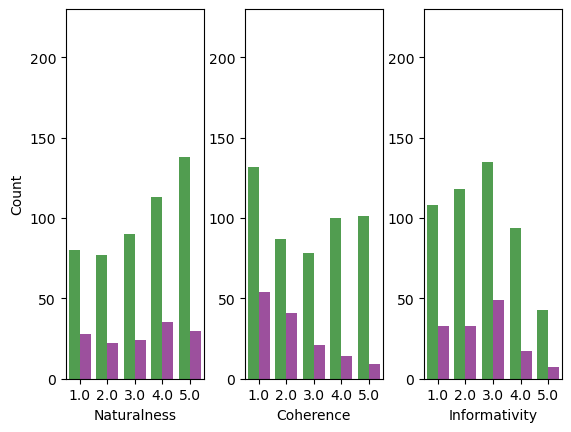

In [21]:
#### subset thedata based on conditions
# here: typical sampling and the unmodified prompt condition
subset = df[(df['DECODING'] == 'typical sampling') & (df['PROMPT_COND'] == 'names_simple')]

# create countplot for NATURALNESS
plt.subplot(131)
sns.countplot(x="NATURALNESS", hue='BIAS', data=subset, palette=['#45AA43',"#A843AA"])
plt.xlabel('Naturalness')
plt.ylabel('Count')
plt.ylim(0, 230) # set y-axis limits to 0-365; 230 for subsets
#plt.title('Informativity')
#plt.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.08), fontsize=10).set_title("Bias Congruency")
plt.legend().remove()

# create countplot for COHERENCE
plt.subplot(132)
sns.countplot(x="COHERENCE", hue='BIAS', data=subset, palette=['#45AA43',"#A843AA"])
plt.xlabel('Coherence')
plt.ylabel('')
plt.ylim(0, 230) # set y-axis limits to 0-365
#plt.title('Naturalness')
plt.legend().remove()

# create countplot for INFORMATIVITY
plt.subplot(133)
sns.countplot(x="INFORMATIVITY", hue='BIAS', data=subset, palette=['#45AA43',"#A843AA"])
plt.xlabel('Informativity')
plt.ylabel('')
plt.ylim(0, 230) # set y-axis limits to 0-365
#plt.title('Coherence')
plt.legend().remove()

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)
# show plot
plt.show()

------
### Correlation analysis (automatic and human evaluation) 

In [22]:
human_ref_df = pd.read_excel("../data/human_and_model_continuations.xlsx")
# human_ref_df 

In [23]:
#### Automatic measures 

## calculate BLEU SCORE and add to the human_ref_df
# Calculate BLEU scores for each row
def calculate_bleu(row):
    prediction = [str(row['continuation'])] 
    references = [row['human_continuations']]    
    bleu_score =  bleu_metric.compute(references=references, predictions = prediction)
    return bleu_score["precisions"][0]

# Apply function to each row of the DataFrame
human_ref_df['bleu_scores'] = human_ref_df.apply(calculate_bleu, axis=1)

## calculate ROUGE-L SCORE and add to the human_ref_df
# Calculate ROUGE scores for each row
def calculate_rouge(row):
    prediction = [str(row['continuation'])]  
    references = [row['human_continuations']]    
    rouge_score =  rouge_metric.compute(references=references, predictions = prediction)
    return rouge_score["rougeL"]

# Apply the function to each row of the DataFrame
human_ref_df['rouge_scores'] = human_ref_df.apply(calculate_rouge, axis=1)

## calculate BERTSCORE and add to the human_ref_df
# Calculate BERTscores for each row
def calculate_bertscore(row):
    prediction = [str(row['continuation'])] 
    references = [row['human_continuations']]    
    bert_score =  bertscore_metric.compute(references=references, predictions = prediction, lang="de")
    return bert_score["f1"][0]

# Apply the function to each row of the DataFrame
human_ref_df['bert_scores'] = human_ref_df.apply(calculate_bertscore, axis=1)

## exclude the human (filler) items
human_ref_df = human_ref_df[human_ref_df['model'] != 'human']

In [24]:
print(human_ref_df)

    prompt condition  exp-list decoding procedure model         verb  \
0      names_simple          2       typical_samp  gpt2  inspirieren   
1      names_simple          1       typical_samp  mGPT  inspirieren   
2      names_simple          1       nucleus_samp  gpt2  inspirieren   
3      names_simple          2       nucleus_samp  mGPT  inspirieren   
4      names_simple          2       diverse_beam  gpt2  inspirieren   
..               ...       ...                ...   ...          ...   
249         names_pp         2       typical_samp  mGPT  enttäuschen   
250         names_pp         2       nucleus_samp  gpt2  enttäuschen   
251         names_pp         1       nucleus_samp  mGPT  enttäuschen   
252         names_pp         1       diverse_beam  gpt2  enttäuschen   
253         names_pp         2       diverse_beam  mGPT  enttäuschen   

    sentiment verb_type gender-order  item  Bias congruent  (1=yes, 0=no)  \
0    positive        SE          m-f     1                

In [26]:
#### Metrics from human evaluation

# rename the dataframe
eval_df = human_ref_df

## calculate the man of each human eval category for each continuation so we can calculate correlations

def add_mean_values(df, item , prompt_condition1, prompt_condition2,
                    decoding_procedure1, decoding_procedure2,
                    model, target_df):
    
    filtered_df = df[(df['ITEM'] == item) & 
                     (df['PROMPT_COND'] == prompt_condition1) & 
                     (df['DECODING'] == decoding_procedure1) & 
                     (df['MODEL'] == model)]
    
    mean_naturalness = filtered_df['NATURALNESS'].mean()
    mean_coherence = filtered_df['COHERENCE'].mean()
    mean_informativity = filtered_df['INFORMATIVITY'].mean()
    
    target_df.loc[(target_df['item'] == item) &
                  (target_df['prompt condition'] == prompt_condition2) & 
                  (target_df['decoding procedure'] == decoding_procedure2) & 
                  (target_df['model'] == model), 'NATURALNESS_MEAN'] = mean_naturalness
    
    target_df.loc[(target_df['item'] == item) &
                  (target_df['prompt condition'] == prompt_condition2) & 
                  (target_df['decoding procedure'] == decoding_procedure2) & 
                  (target_df['model'] == model), 'COHERENCE_MEAN'] = mean_coherence
    
    target_df.loc[(target_df['item'] == item) &
                  (target_df['prompt condition'] == prompt_condition2) & 
                  (target_df['decoding procedure'] == decoding_procedure2) & 
                  (target_df['model'] == model), 'INFORMATIVITY_MEAN'] = mean_informativity


In [27]:
#### apply to all items 
## nucleus sampling
for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="nucleus sampling", 
                    decoding_procedure2="nucleus_samp",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="nucleus sampling", 
                    decoding_procedure2="nucleus_samp",
                    model="mGPT", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="nucleus sampling", 
                    decoding_procedure2="nucleus_samp",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="nucleus sampling", 
                    decoding_procedure2="nucleus_samp",
                    model="mGPT", 
                    target_df=eval_df)
    
#################### 
##### diverse beam search 
for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="diverse beam search", 
                    decoding_procedure2="diverse_beam",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="diverse beam search", 
                    decoding_procedure2="diverse_beam",
                    model="mGPT", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="diverse beam search", 
                    decoding_procedure2="diverse_beam",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="diverse beam search", 
                    decoding_procedure2="diverse_beam",
                    model="mGPT", 
                    target_df=eval_df)
    
####################
##### typical sampling
for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="typical sampling", 
                    decoding_procedure2="typical_samp",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_simple", 
                    prompt_condition2="names_simple ", 
                    decoding_procedure1="typical sampling", 
                    decoding_procedure2="typical_samp",
                    model="mGPT", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="typical sampling", 
                    decoding_procedure2="typical_samp",
                    model="gpt2", 
                    target_df=eval_df)

for item in range(1, 33):
    add_mean_values(df=df, item=item, 
                    prompt_condition1="names_pp", 
                    prompt_condition2="names_pp", 
                    decoding_procedure1="typical sampling", 
                    decoding_procedure2="typical_samp",
                    model="mGPT", 
                    target_df=eval_df)

In [28]:
## save everything
#eval_df.to_excel("../data/results_for_correlation_analysis.xlsx")

In [32]:
eval_df= pd.read_excel("../data/results_for_correlation_analysis.xlsx")

#### now calculate correlation

In [33]:
# Define the combinations for correlation calculation
combinations = [('bleu_scores', 'NATURALNESS_MEAN'),
               ('bleu_scores', 'COHERENCE_MEAN'),
               ('bleu_scores', 'INFORMATIVITY_MEAN'),
               ('bert_scores', 'NATURALNESS_MEAN'),
               ('bert_scores', 'COHERENCE_MEAN'),
               ('bert_scores', 'INFORMATIVITY_MEAN'),
               ('rouge_scores', 'NATURALNESS_MEAN'),
               ('rouge_scores', 'COHERENCE_MEAN'),
               ('rouge_scores', 'INFORMATIVITY_MEAN')]

# Initialize lists to store correlation coefficients and p-values
correlation_coeffs = []
p_values = []

# Calculate Pearson's correlation coefficient and p-value for each combination
for combo in combinations:
    col1, col2 = combo
    
    # Drop rows with missing values in the two columns
    cleaned_df = eval_df[[col1, col2]].dropna()
    
    # Calculate Pearson's correlation coefficient and p-value
    correlation_coeff, p_value = pearsonr(cleaned_df[col1], cleaned_df[col2])
    
    # Append correlation coefficient and p-value to lists
    correlation_coeffs.append(correlation_coeff)
    p_values.append(p_value)

# Create a DataFrame to store the correlation results
results_table = pd.DataFrame({
    'Measure 1': [combo[0] for combo in combinations],
    'Measure 2': [combo[1] for combo in combinations],
    'Correlation Coefficient': correlation_coeffs,
    'p-value': p_values
})

# Convert the DataFrame to LaTeX table format
latex_table = results_table.to_latex(index=False, float_format="%.3f", column_format='p{1.6cm}p{1.6cm}p{2cm}p{1.6cm}')

# Add \usepackage{booktabs} to the LaTeX table
latex_table = latex_table.replace(r'\begin{tabular}{', r'\begin{tabular}{@{}')

# Replace \toprule with \toprule and \midrule with \cmidrule
latex_table = latex_table.replace(r'\toprule', r'\toprule \addlinespace')
latex_table = latex_table.replace(r'\midrule', r'\cmidrule(lr){1-4} \addlinespace')

# Add \bottomrule at the end of the table
latex_table = latex_table.rstrip() + r'\addlinespace \bottomrule'

# Print the LaTeX table
print(latex_table)


\begin{tabular}{@{}p{1.6cm}p{1.6cm}p{2cm}p{1.6cm}}
\toprule \addlinespace
   Measure 1 &          Measure 2 &  Correlation Coefficient &  p-value \\
\cmidrule(lr){1-4} \addlinespace
 bleu\_scores &   NATURALNESS\_MEAN &                    0.164 &    0.026 \\
 bleu\_scores &     COHERENCE\_MEAN &                    0.184 &    0.012 \\
 bleu\_scores & INFORMATIVITY\_MEAN &                   -0.179 &    0.015 \\
 bert\_scores &   NATURALNESS\_MEAN &                   -0.040 &    0.590 \\
 bert\_scores &     COHERENCE\_MEAN &                   -0.008 &    0.911 \\
 bert\_scores & INFORMATIVITY\_MEAN &                   -0.069 &    0.352 \\
rouge\_scores &   NATURALNESS\_MEAN &                   -0.015 &    0.843 \\
rouge\_scores &     COHERENCE\_MEAN &                    0.033 &    0.655 \\
rouge\_scores & INFORMATIVITY\_MEAN &                   -0.078 &    0.296 \\
\bottomrule
\end{tabular}\addlinespace \bottomrule


/var/folders/28/g5by9h753bl2jl0601v064bc0000gn/T/ipykernel_83135/2346146410.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_table.to_latex(index=False, float_format="%.3f", column_format='p{1.6cm}p{1.6cm}p{2cm}p{1.6cm}')
